# Project Data Analysis : Brazilian E-Commerce Public Dataset by Olist
---
- Name: Reinaldo Yosafat Gultom
- Email: reinaldogultom@gmail.com

in this file, the analysis process will be carried out using the Bike Sharing Dataset which can be seen at the [following link](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

## About Dataset
---
This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.


### Dataset Dictionary

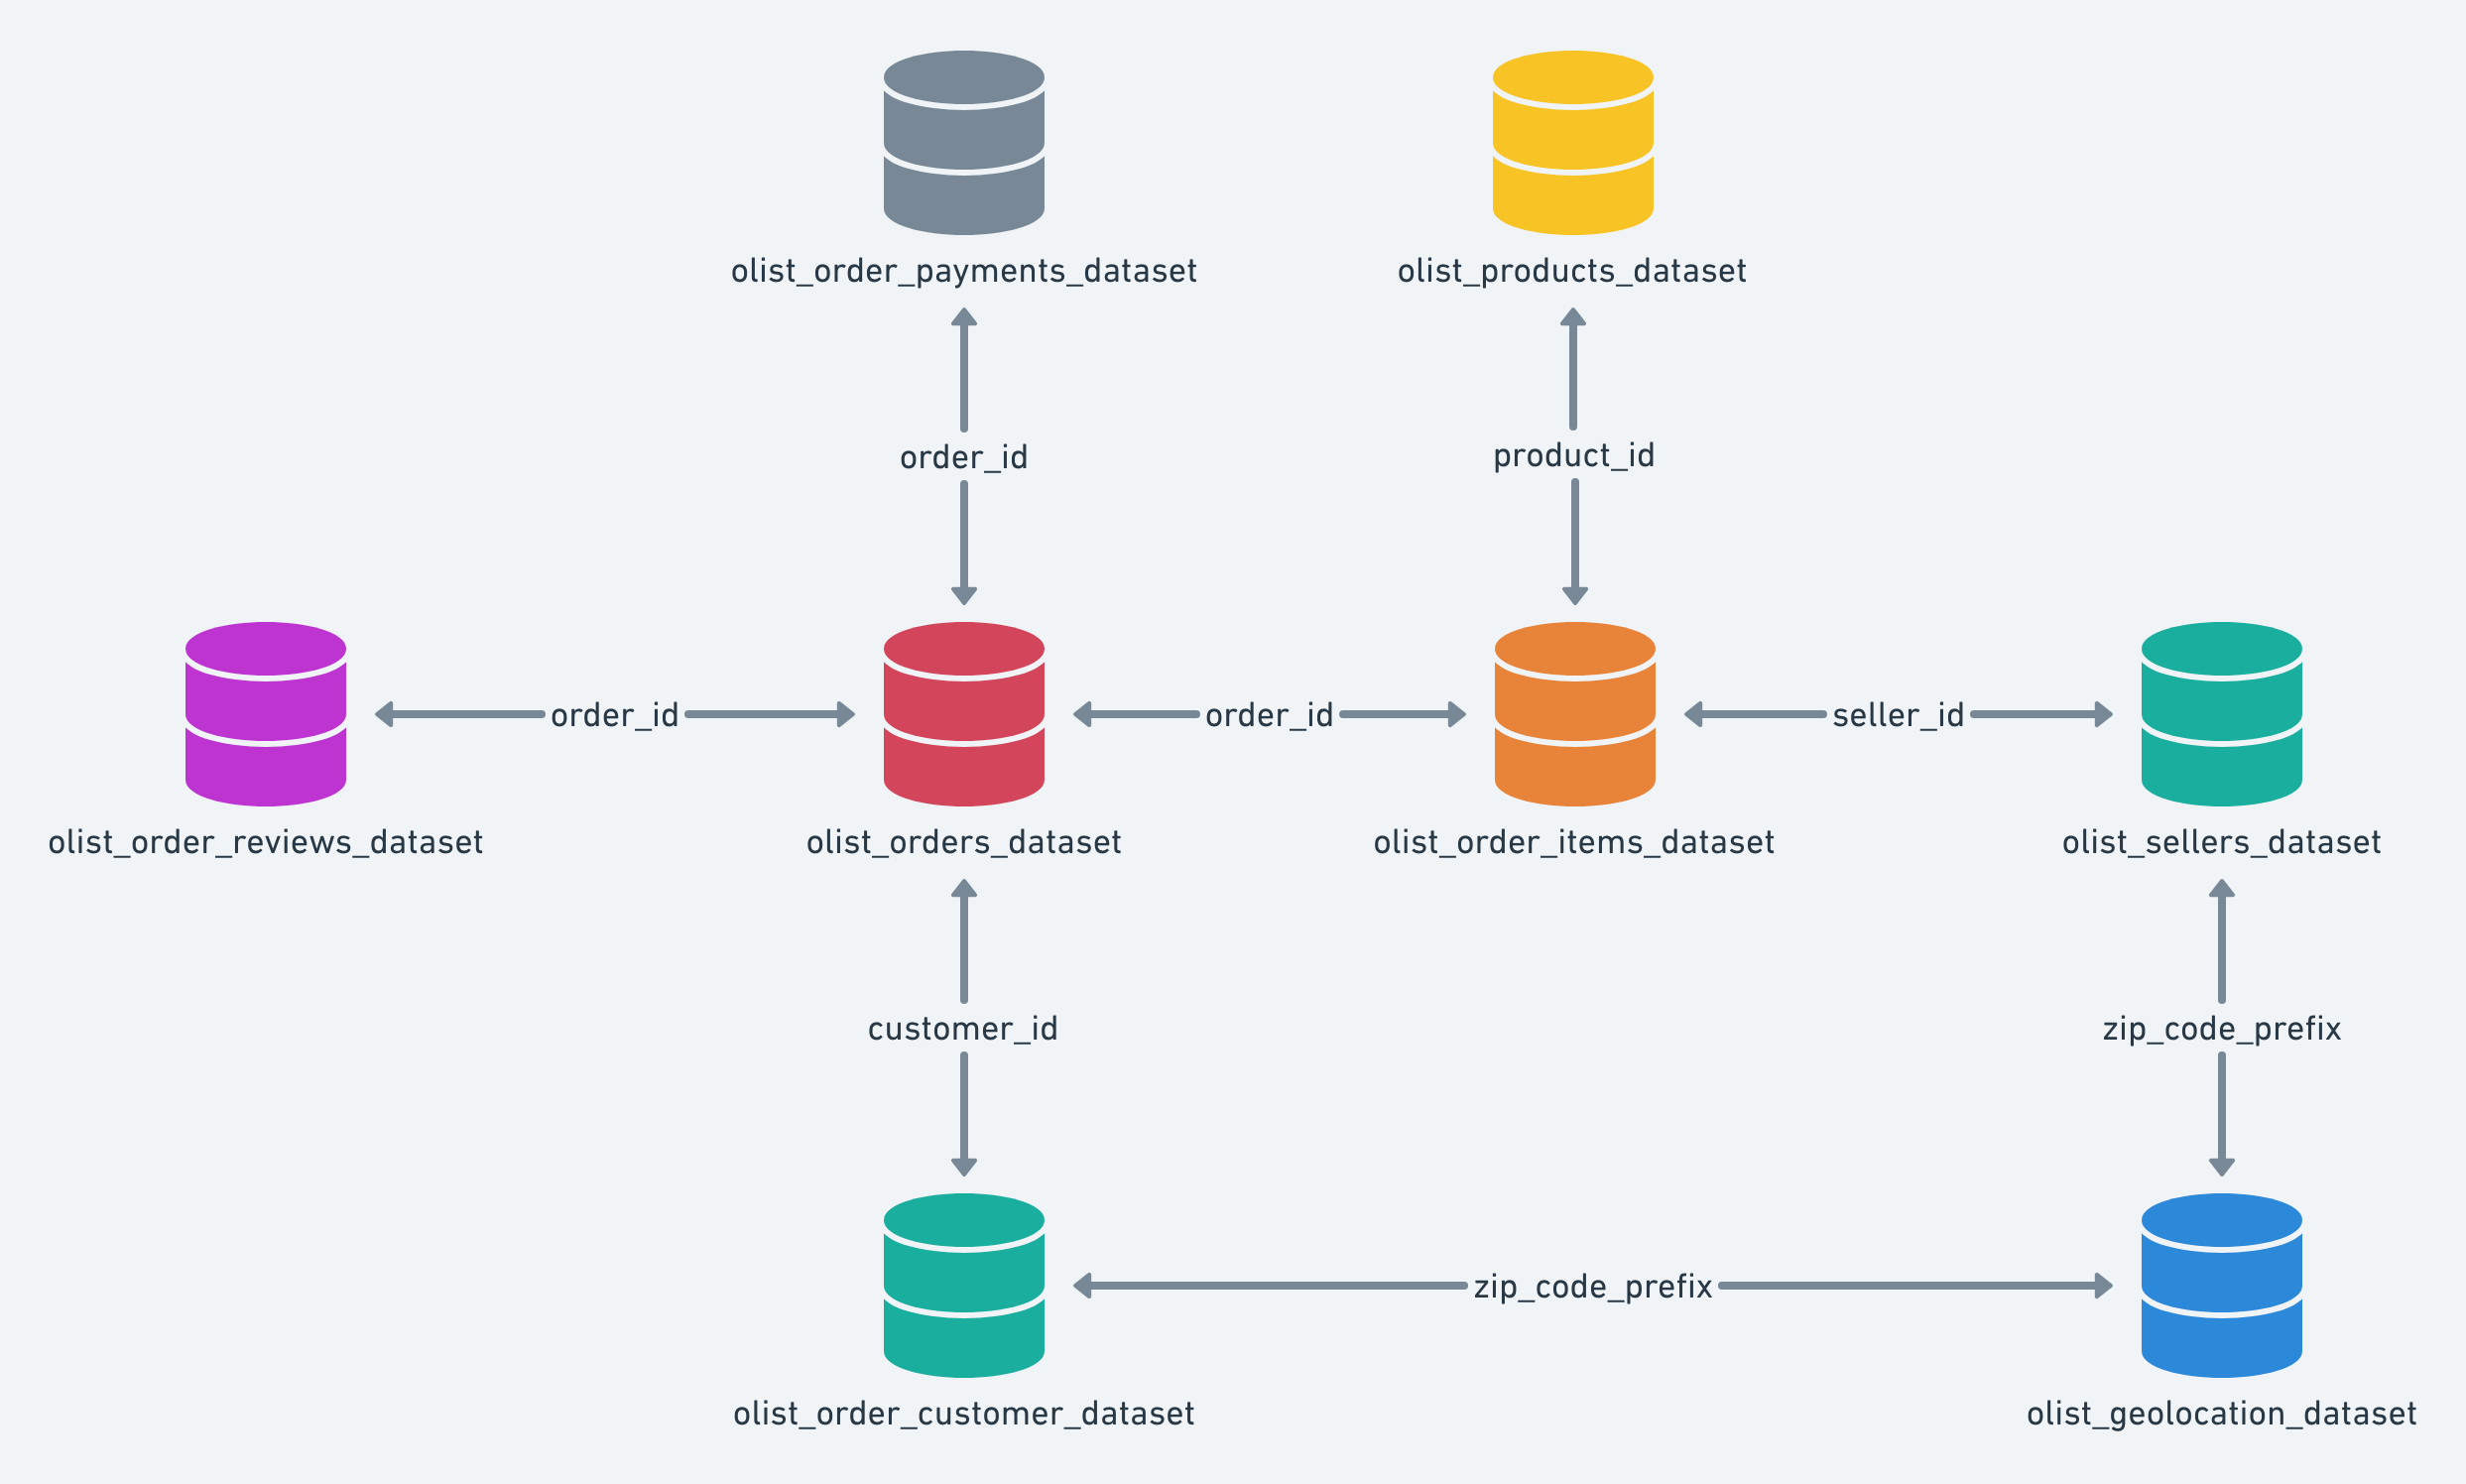

### Dataset Attention

- An order might have multiple items.
- Each item might be fulfilled by a distinct seller.
- All text identifying stores and partners where replaced by the names of Game of Thrones great houses.

## 1. Defining Business Questions
---
- How are E-Commerce Around Brazil?
- How are the customer distribution of Brazilian E-Commerce? 
- How are E-Commerce Impact on Economy?
- How are Payment Type usage of Brazilian E-Commerce?
- How are Price Distribution of Brazilian E-Commerce?

## 2. Import Libraries
---
import libraries that we need for data analysis and visualization.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Helper Function

In [5]:
def data_overview(df, corr=False, label_name=None, sort_by='qtd_null', thresh_percent_null=0, thresh_corr_label=0):
    """
    Steps:
        1. Identify attributes with missing values in the set
        2. Analyze the primitive type of each attribute
        3. Analyze the number of entries in case of categorical attributes
        4. Extract the Pearson correlation with the target for each attribute
        5. Apply rules defined in the arguments
        6. Return the created overview dataset

    Arguments:
        df -- DataFrame to be analyzed [pandas.DataFrame]
        label_name -- name of the target variable [string]
        sort_by -- column to sort the overview dataset [string - default: 'qtd_null']
        thresh_percent_null -- filter for missing values [int - default: 0]
        threh_corr_label -- filter for correlation with the target [int - default: 0]

    Return
        df_overview -- consolidated dataset containing column analysis [pandas.DataFrame]
    """
    
    # Create DataFrame with information about missing values
    df_null = pd.DataFrame(df.isnull().sum()).reset_index()
    df_null.columns = ['feature', 'qtd_null']
    df_null['percent_null'] = df_null['qtd_null'] / len(df)

    # Return primitive type and qtd of entries for categorical
    df_null['dtype'] = df_null['feature'].apply(lambda x: df[x].dtype)
    df_null['qtd_cat'] = [len(df[col].value_counts()) if df[col].dtype == 'object' else 0 for col in
                          df_null['feature'].values]

    if corr:
        # Extract correlation information with the target
        label_corr = pd.DataFrame(df.corr()[label_name])
        label_corr = label_corr.reset_index()
        label_corr.columns = ['feature', 'target_pearson_corr']

        # Merge information
        df_null_overview = df_null.merge(label_corr, how='left', on='feature')
        df_null_overview.query('target_pearson_corr > @thresh_corr_label')
    else:
        df_null_overview = df_null

    # Filter missing values according to thresholds
    df_null_overview.query('percent_null > @thresh_percent_null')

    # Sort DataFrame
    df_null_overview = df_null_overview.sort_values(by=sort_by, ascending=False)
    df_null_overview = df_null_overview.reset_index(drop=True)

    return df_null_overview

In [6]:
def format_spines(ax, right_border=True):
    """
    This function sets up borders from an axis and personalize colors

    Input:
        Axis and a flag for deciding or not to plot the right border
    Returns:
        Plot configuration
    """
    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

In [7]:
def single_countplot(df, ax, x=None, y=None, top=None, order=True, hue=False, palette='plasma',
                     width=0.75, sub_width=0.3, sub_size=12):
    """
    Parameters
    ----------
    df: DataFrame containing the data for plotting.
    ax: The axes object where the countplot will be drawn.
    x: The variable to be plotted on the x-axis (optional).
    y: The variable to be plotted on the y-axis (optional).
    top: Number of top categories to display in the plot (optional).
    order: Whether to sort categories by frequency (default is True).
    hue: Variable to divide the data and use different colors to represent the divisions (optional).
    palette: Color palette to be used for the plot (default is 'plasma').
    width: Width of the bars in the countplot (default is 0.75).
    sub_width: Width of sub-plots (if used, default is 0.3).
    sub_size: Font size for sub-plots (if used, default is 12).

    Returns
    -------
    None
    """

    # Checking for plotting by breaking down a categorical variable
    ncount = len(df)
    if x:
        col = x
    else:
        col = y

    # Checking for plotting the top categories
    if top is not None:
        cat_count = df[col].value_counts()
        top_categories = cat_count[:top].index
        df = df[df[col].isin(top_categories)]

    # Validating other arguments and plotting the graph
    if hue != False:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index, hue=hue)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, hue=hue)
    else:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax)

    # Formatting axes
    format_spines(ax, right_border=False)

    # Adding percentage labels
    if x:
        for p in ax.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), ha='center', va='bottom')
    else:
        for p in ax.patches:
            x = p.get_bbox().get_points()[1, 0]
            y = p.get_bbox().get_points()[:, 1]
            ax.annotate('{} ({:.1f}%)'.format(int(x), 100. * x / ncount), (x, y.mean()), va='center')


## 3. Data Wrangling
------
Data wrangling is the process of cleaning, transforming, and organizing raw and unstructured data into a structured format suitable for analysis. It involves tasks like removing inconsistencies, handling missing values, and converting data into a usable and coherent form for further data analysis and modeling.

### 3.1. Gathering Data
There is a table with .csv format in this dataset, namely hour.csv. the data is then loaded using the pandas library

In [8]:
df_item = pd.read_csv("order_items_dataset.csv")
df_reviews = pd.read_csv("order_reviews_dataset.csv")
df_orders = pd.read_csv("orders_dataset.csv")
df_products = pd.read_csv("products_dataset.csv")
df_geolocation = pd.read_csv("geolocation_dataset.csv")
df_sellers = pd.read_csv("sellers_dataset.csv")
df_order_pay = pd.read_csv("order_payments_dataset.csv")
df_customers = pd.read_csv("customers_dataset.csv")
df_category = pd.read_csv("product_category_name_translation.csv")

### 3.2 Assessing Data
At this step, the quality of the data will be considered whether there are any problems with the dataframes that have been collected.
There are several problems that commonly happen to the data including:
1. missing value
2. duplicate value
3. inconsistant data
4. Invalid value
5. Inaccurate value
6. outlier

In [9]:
datasets = [df_item, df_reviews, df_orders, df_products, df_geolocation,
            df_sellers, df_order_pay, df_customers, df_category]
names = ['df_item', 'df_reviews', 'df_orders', 'df_products', 'df_geolocation',
         'df_sellers', 'df_order_pay', 'df_customers', 'df_category']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,df_item,112650,7,0,0,
1,df_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
2,df_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,df_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
4,df_geolocation,1000163,5,0,0,
5,df_sellers,3095,4,0,0,
6,df_order_pay,103886,5,0,0,
7,df_customers,99441,5,0,0,
8,df_category,71,2,0,0,


In [10]:
datasets = [df_item, df_reviews, df_orders, df_products, df_geolocation,
            df_sellers, df_order_pay, df_customers, df_category]
names = ['df_item', 'df_reviews', 'df_orders', 'df_products', 'df_geolocation',
         'df_sellers', 'df_order_pay', 'df_customers', 'df_category']

df_overview = pd.DataFrame({})
name_col = []
for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = df_overview.append(data_overview(df))
    df_overview['dataset_name'] = name_col

df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
df_overview

C:\Users\Reinaldo\AppData\Local\Temp\ipykernel_26956\2505664363.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_overview = df_overview.append(data_overview(df))
C:\Users\Reinaldo\AppData\Local\Temp\ipykernel_26956\2505664363.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_overview = df_overview.append(data_overview(df))
C:\Users\Reinaldo\AppData\Local\Temp\ipykernel_26956\2505664363.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_overview = df_overview.append(data_overview(df))
C:\Users\Reinaldo\AppData\Local\Temp\ipykernel_26956\2505664363.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_overview = df_ove

,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
0,df_item,order_id,0,0.000000,object,98666
1,df_item,order_item_id,0,0.000000,int64,0
2,df_item,product_id,0,0.000000,object,32951
3,df_item,seller_id,0,0.000000,object,3095
4,df_item,shipping_limit_date,0,0.000000,object,93318
5,df_item,price,0,0.000000,float64,0
6,df_item,freight_value,0,0.000000,float64,0
0,df_reviews,review_comment_title,87656,0.883415,object,4527
1,df_reviews,review_comment_message,58247,0.587025,object,36159
2,df_reviews,review_id,0,0.000000,object,98410


In [14]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [15]:
df_products['product_category_name'].unique()

array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
       'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
       'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
       'cama_mesa_banho', 'construcao_ferramentas_seguranca',
       'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
       'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
       'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
       'relogios_presentes', 'construcao_ferramentas_construcao',
       'pet_shop', 'eletroportateis', 'agro_industria_e_comercio', nan,
       'moveis_sala', 'sinalizacao_e_seguranca', 'climatizacao',
       'consoles_games', 'livros_interesse_geral',
       'construcao_ferramentas_ferramentas',
       'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'industria_comercio_e_negocios', 'telefonia_fixa',
   

In [16]:
df_main = df_orders.merge(df_item, on='order_id', how='left')
df_main = df_main.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_main = df_main.merge(df_products, on='product_id', how='outer')
df_main = df_main.merge(df_customers, on='customer_id', how='outer')
df_main = df_main.merge(df_sellers, on='seller_id', how='outer')

print(df_main.shape)

(118434, 33)


### 3.3. Cleaning Data
From the problems that have been obtained in stage 2.2, this stage will try to clean up the problems that have been identified.

In [17]:
df_main = df_main.dropna()

### Showing the result of the table after Cleaning data

### Saving The Modified Dataset

## 5. Visualization and Answer
---


### Geographic based on Zip Codes

In [18]:
df_geolocation_copy = df_geolocation.copy()
df_geolocation_copy = df_geolocation_copy.astype(str)


In [21]:
df_geolocation_copy.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.54562128115268,-46.63929204800168,sao paulo,SP
1,1046,-23.54608112703553,-46.64482029837157,sao paulo,SP
2,1046,-23.54612896641469,-46.64295148361138,sao paulo,SP
3,1041,-23.5443921648681,-46.63949930627844,sao paulo,SP
4,1035,-23.541577961711493,-46.64160722329613,sao paulo,SP


In [22]:
df_geolocation_copy['geolocation_zip_code_prefix_1_digits'] = df_geolocation_copy['geolocation_zip_code_prefix'].str[0:1]
df_geolocation_copy['geolocation_zip_code_prefix_2_digits'] = df_geolocation_copy['geolocation_zip_code_prefix'].str[0:2]
df_geolocation_copy['geolocation_zip_code_prefix_3_digits'] = df_geolocation_copy['geolocation_zip_code_prefix'].str[0:3]
df_geolocation_copy['geolocation_zip_code_prefix_4_digits'] = df_geolocation_copy['geolocation_zip_code_prefix'].str[0:4]
df_geolocation_copy.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_zip_code_prefix_1_digits,geolocation_zip_code_prefix_2_digits,geolocation_zip_code_prefix_3_digits,geolocation_zip_code_prefix_4_digits
0,1037,-23.54562128115268,-46.63929204800168,sao paulo,SP,1,10,103,1037
1,1046,-23.54608112703553,-46.64482029837157,sao paulo,SP,1,10,104,1046
2,1046,-23.54612896641469,-46.64295148361138,sao paulo,SP,1,10,104,1046


In [24]:
# using dictionary to convert specific columns
convert_dict = {'geolocation_lat': float,
                'geolocation_lng': float
                }
 
df_geolocation_copy = df_geolocation_copy.astype(convert_dict)

In [25]:
# Removing some outliers
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
df_geolocation_copy = df_geolocation_copy[df_geolocation_copy.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
df_geolocation_copy = df_geolocation_copy[df_geolocation_copy.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
df_geolocation_copy = df_geolocation_copy[df_geolocation_copy.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
df_geolocation_copy = df_geolocation_copy[df_geolocation_copy.geolocation_lng <=  -34.79314722]

In [26]:
from datashader.utils import lnglat_to_meters as webm
x, y = webm(df_geolocation_copy.geolocation_lng, df_geolocation_copy.geolocation_lat)
df_geolocation_copy['x'] = pd.Series(x)
df_geolocation_copy['y'] = pd.Series(y)

In [27]:
# transforming the prefixes to int for plotting purposes
df_geolocation_copy['geolocation_zip_code_prefix'] = df_geolocation_copy['geolocation_zip_code_prefix'].astype(int)
df_geolocation_copy['geolocation_zip_code_prefix_1_digits'] = df_geolocation_copy['geolocation_zip_code_prefix_1_digits'].astype(int)
df_geolocation_copy['geolocation_zip_code_prefix_2_digits'] = df_geolocation_copy['geolocation_zip_code_prefix_2_digits'].astype(int)
df_geolocation_copy['geolocation_zip_code_prefix_3_digits'] = df_geolocation_copy['geolocation_zip_code_prefix_3_digits'].astype(int)
df_geolocation_copy['geolocation_zip_code_prefix_4_digits'] = df_geolocation_copy['geolocation_zip_code_prefix_4_digits'].astype(int)

In [28]:
position_map = df_geolocation_copy
agg_name = 'geolocation_zip_code_prefix'
position_map[agg_name].describe().to_frame()

,geolocation_zip_code_prefix
count,1.000121e+06
mean,3.657332e+04
std,3.054939e+04
min,1.001000e+03
25%,1.107500e+04
50%,2.653000e+04
75%,6.350400e+04
max,9.999000e+04


In [29]:
position_map.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_zip_code_prefix_1_digits,geolocation_zip_code_prefix_2_digits,geolocation_zip_code_prefix_3_digits,geolocation_zip_code_prefix_4_digits,x,y
0,1037,-23.545621,-46.639292,sao paulo,SP,1,10,103,1037,-5.191862e+06,-2.698137e+06
1,1046,-23.546081,-46.644820,sao paulo,SP,1,10,104,1046,-5.192478e+06,-2.698193e+06
2,1046,-23.546129,-46.642951,sao paulo,SP,1,10,104,1046,-5.192270e+06,-2.698199e+06
3,1041,-23.544392,-46.639499,sao paulo,SP,1,10,104,1041,-5.191885e+06,-2.697988e+06
4,1035,-23.541578,-46.641607,sao paulo,SP,1,10,103,1035,-5.192120e+06,-2.697646e+06


Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
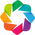

In [30]:
# plot wtih holoviews + datashader - bokeh with map background
import holoviews as hv
import geoviews as gv
import datashader as ds
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr
from datashader.colors import colormap_select, Greys9
from holoviews.streams import RangeXY
from holoviews.operation.datashader import datashade, dynspread, rasterize
from bokeh.io import push_notebook, show, output_notebook
output_notebook()
hv.extension('bokeh')

%opts Overlay [width=800 height=600 toolbar='above' xaxis=None yaxis=None]
%opts QuadMesh [tools=['hover'] colorbar=True] (alpha=0 hover_alpha=0.2)

T = 0.05
PX = 1



In [31]:
def plot_map(data, label, agg_data, agg_name, cmap):
    url="http://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{Z}/{Y}/{X}.png"
    geomap = gv.WMTS(url)
    points = hv.Points(gv.Dataset(data, kdims=['x', 'y'], vdims=[agg_name]))
    agg = datashade(points, element_type=gv.Image, aggregator=agg_data, cmap=cmap)
    zip_codes = dynspread(agg, threshold=T, max_px=PX)
    hover = hv.util.Dynamic(rasterize(points, aggregator=agg_data, width=50, height=25, streams=[RangeXY]), operation=hv.QuadMesh)
    hover = hover.options(cmap=cmap)
    img = geomap * zip_codes * hover
    img = img.relabel(label)
    return img

In [32]:
plot_map(position_map, 'Zip Codes in Brazil', ds.min(agg_name), agg_name, cmap=rainbow)

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [x,y]   (R,G,B,A)
      .QuadMesh.I :QuadMesh   [x,y]   (x_y geolocation_zip_code_prefix)

<Axes: xlabel='geolocation_state', ylabel='count'>

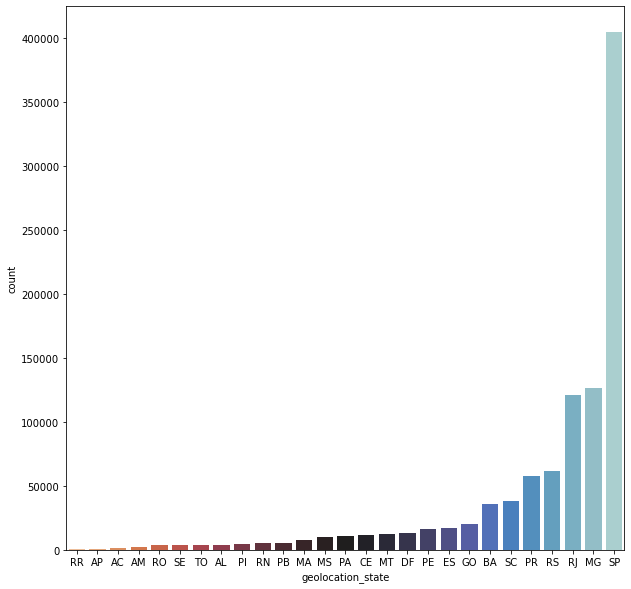

In [34]:
plt.figure(figsize=(10,10))
sns.countplot(x ='geolocation_state', data=df_geolocation_copy, 
              order=df_geolocation_copy['geolocation_state'].value_counts().sort_values().index, 
              palette='icefire_r')

### Barplot orders for each status

In [44]:
df_orders_customer = df_orders.merge(df_customers, how='left', on='customer_id')
df_orders_customer.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_time_day,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,Morning,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Night,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,Morning,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,Night,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,Night,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [45]:
print(df_orders_customer['order_status'].value_counts())

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64


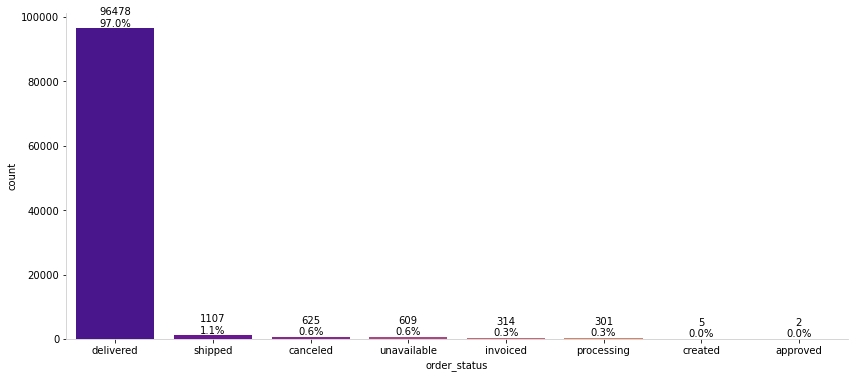

In [46]:
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_status', ax=ax)
plt.show()

In [47]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders_customer[col] = pd.to_datetime(df_orders[col])

In [48]:
df_orders_customer.info()
df_orders_customer

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   order_purchase_time_day        99441 non-null  category      
 9   customer_unique_id             99441 non-null  object        
 10  customer_zip_code_prefix       99441 non-null  int64         
 11  customer_city  

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_time_day,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,Morning,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,Night,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,Morning,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,Night,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,Night,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,Morning,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,Morning,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,Afternoon,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,Night,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [42]:
# Extracting attributes for purchase date - Year and Month
df_orders_customer['order_purchase_year'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders_customer['order_purchase_month'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders_customer['order_purchase_month_name'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders_customer['order_purchase_year_month'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders_customer['order_purchase_date'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders_customer['order_purchase_day'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders_customer['order_purchase_dayofweek'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders_customer['order_purchase_dayofweek_name'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders_customer['order_purchase_hour'] = df_orders_customer['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders_customer['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,Night


C:\Users\Reinaldo\AppData\Local\Temp\ipykernel_23292\1460727309.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


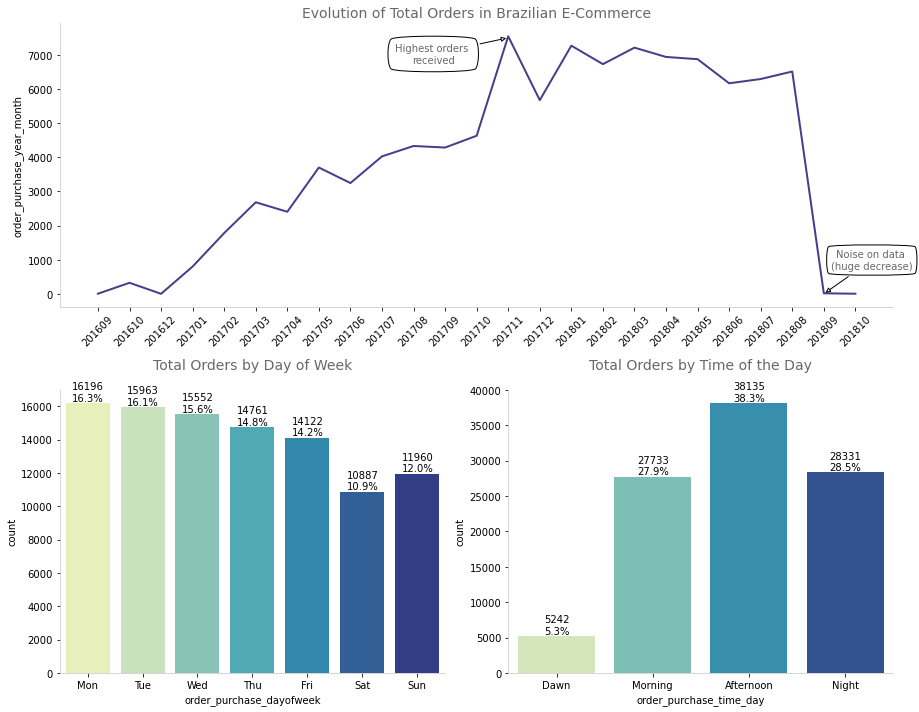

In [32]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders_customer['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders_customer, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette='YlGnBu')
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

### Customer Top 10 Product

In [33]:
#Merge data
total_orders=pd.merge(df_orders, df_item)
df_orders_item_products=pd.merge(total_orders,df_products, on="product_id")
df_orders_item_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   order_id                       112650 non-null  object  
 1   customer_id                    112650 non-null  object  
 2   order_status                   112650 non-null  object  
 3   order_purchase_timestamp       112650 non-null  object  
 4   order_approved_at              112635 non-null  object  
 5   order_delivered_carrier_date   111456 non-null  object  
 6   order_delivered_customer_date  110196 non-null  object  
 7   order_estimated_delivery_date  112650 non-null  object  
 8   order_purchase_time_day        112650 non-null  category
 9   order_item_id                  112650 non-null  int64   
 10  product_id                     112650 non-null  object  
 11  seller_id                      112650 non-null  object  
 12  shipping_limit_d

In [34]:
df_orders_item_products['product_id_shorten']=df_orders_item_products['product_id'].str[-8:]

Text(0.5, 1.0, 'Top 10 Products')

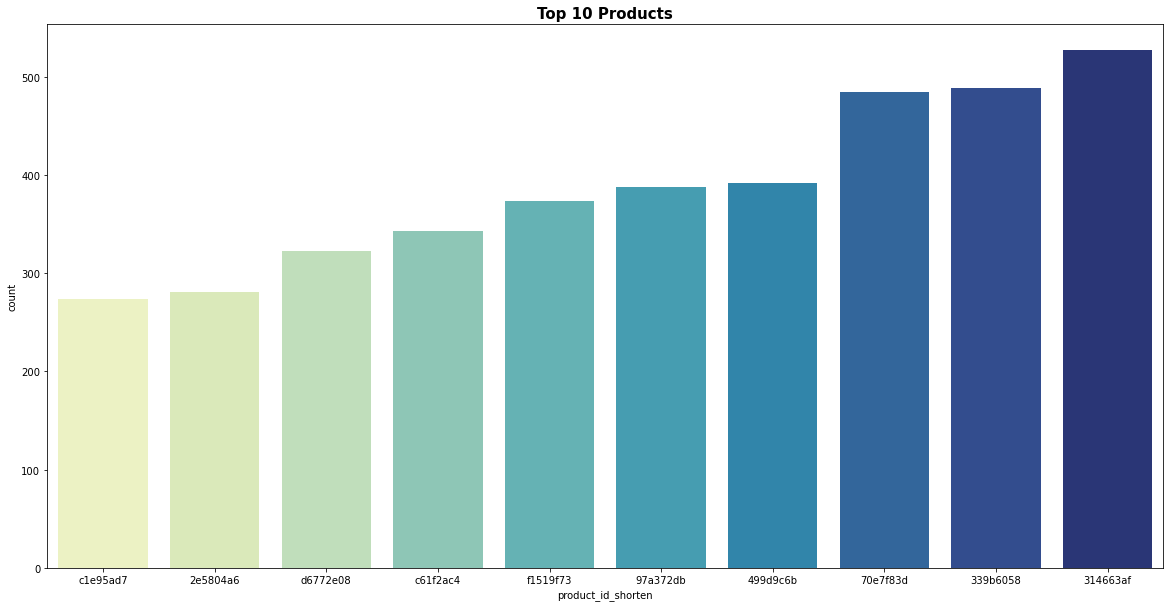

In [36]:
#Plotting Top 10 Products
plt.figure(figsize=(20,10))
sns.countplot(x='product_id_shorten', data=df_orders_item_products, palette='YlGnBu',
             order=df_orders_item_products['product_id_shorten'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

Text(0.5, 1.0, 'Top 10 product_category_name')

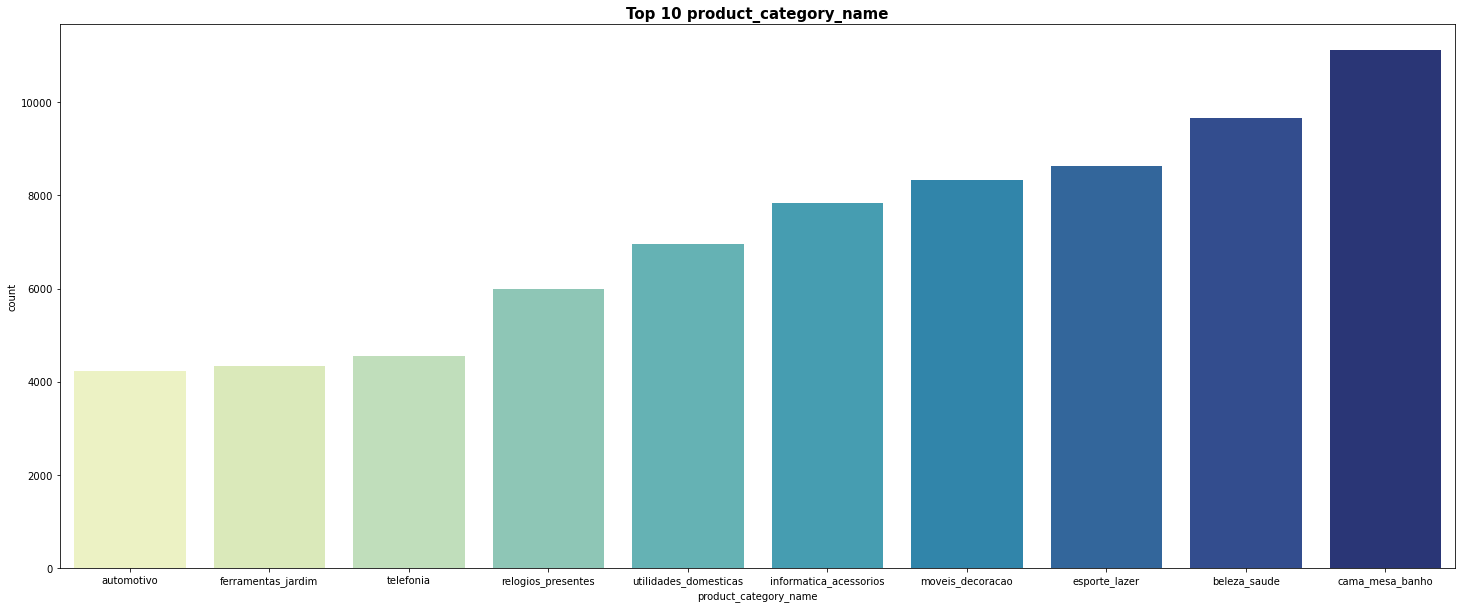

In [39]:
plt.figure(figsize=(25,10))
sns.countplot(x='product_category_name', data=df_orders_item_products, palette='YlGnBu',
             order=df_orders_item_products['product_category_name'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 product_category_name", fontsize=15,
                                             weight='bold')

NameError: name 'df_float' is not defined

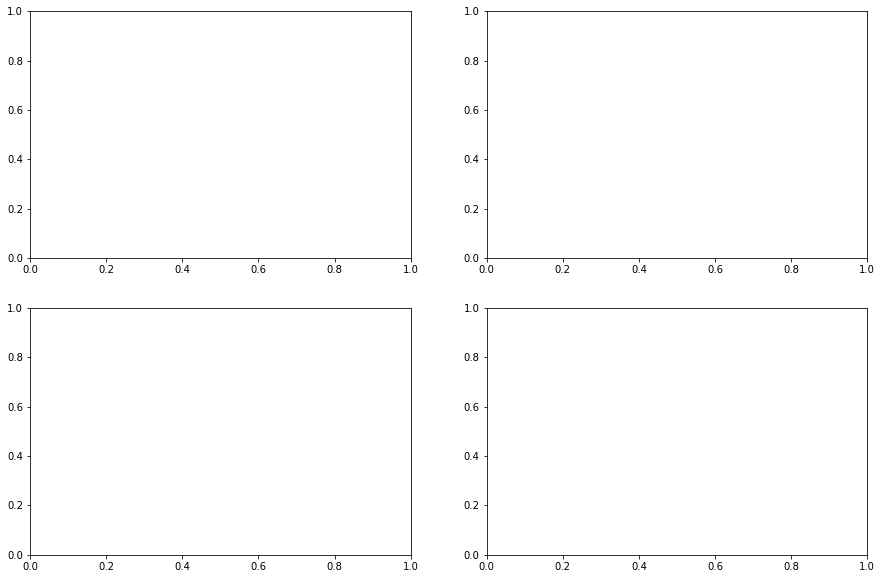

In [111]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Iterate over the float variables and create a histogram for each one
for i in range(4):
    row, col = divmod(i, 2)
    ax = axs[row, col]### Geographic based on Zip Codes
    sns.histplot(x=df_float[float_vars[i]], ax=ax, kde=True, bins=10, color='blue')
    
    # Set the title and labels
    ax.set_title(float_vars[i])
    ax.set_xlabel("")
    ax.set_ylabel("")
    
# Adjust the layout of the subplots
plt.tight_layout()

plt.show()


### Boxplot IQR 

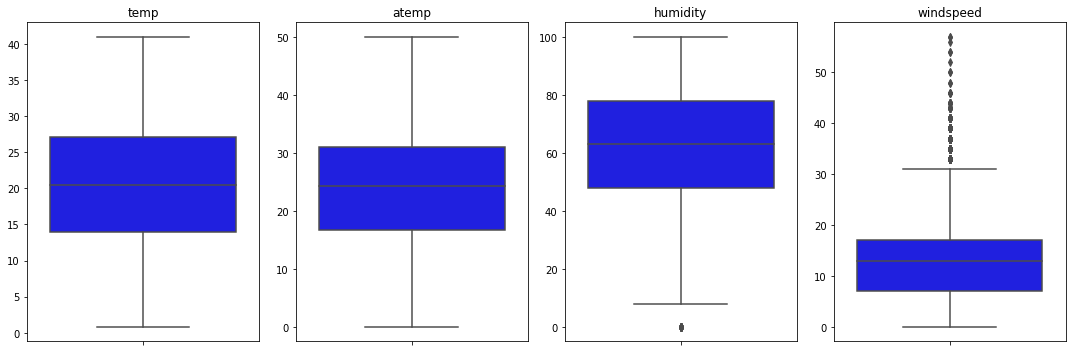

In [22]:
# Create a figure and 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Iterate over the float variables and create a boxplot for each one
for i, ax in enumerate(axs):
    sns.boxplot(y=df_float[float_vars[i]], orient='v', ax=ax, color='blue')

    # Set the title and labels
    ax.set_title(float_vars[i])
    ax.set_ylabel("")

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
df_float.shape

(17379, 4)

There are some outlier data obtained after the iqr plot, so we can drop the data in the following way:

In [24]:
def remove_outlier_IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3-Q1
    df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

In [25]:
hour_df

,instant,dteday,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,2011-01-01,Winter,2011,January,0,0,Saturday,0,1,9.84,14.395,81.0,0.0000,3,13,16
1,2,2011-01-01,Winter,2011,January,1,0,Saturday,0,1,9.02,13.635,80.0,0.0000,8,32,40
2,3,2011-01-01,Winter,2011,January,2,0,Saturday,0,1,9.02,13.635,80.0,0.0000,5,27,32
3,4,2011-01-01,Winter,2011,January,3,0,Saturday,0,1,9.84,14.395,75.0,0.0000,3,10,13
4,5,2011-01-01,Winter,2011,January,4,0,Saturday,0,1,9.84,14.395,75.0,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,Winter,2012,December,19,0,Monday,1,2,10.66,12.880,60.0,11.0014,11,108,119
17375,17376,2012-12-31,Winter,2012,December,20,0,Monday,1,2,10.66,12.880,60.0,11.0014,8,81,89
17376,17377,2012-12-31,Winter,2012,December,21,0,Monday,1,1,10.66,12.880,60.0,11.0014,7,83,90
17377,17378,2012-12-31,Winter,2012,December,22,0,Monday,1,1,10.66,13.635,56.0,8.9981,13,48,61


In [26]:
df_outlier_removed = remove_outlier_IQR(df_float)
df_outlier_removed = pd.DataFrame(df_outlier_removed)
ind_diff = hour_df.index.difference(df_outlier_removed.index)


In [27]:
hour_df = hour_df.drop(ind_diff)
hour_df.reset_index(inplace=True)

In [28]:
hour_df

,index,instant,dteday,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,0,1,2011-01-01,Winter,2011,January,0,0,Saturday,0,1,9.84,14.395,81.0,0.0000,3,13,16
1,1,2,2011-01-01,Winter,2011,January,1,0,Saturday,0,1,9.02,13.635,80.0,0.0000,8,32,40
2,2,3,2011-01-01,Winter,2011,January,2,0,Saturday,0,1,9.02,13.635,80.0,0.0000,5,27,32
3,3,4,2011-01-01,Winter,2011,January,3,0,Saturday,0,1,9.84,14.395,75.0,0.0000,3,10,13
4,4,5,2011-01-01,Winter,2011,January,4,0,Saturday,0,1,9.84,14.395,75.0,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17011,17374,17375,2012-12-31,Winter,2012,December,19,0,Monday,1,2,10.66,12.880,60.0,11.0014,11,108,119
17012,17375,17376,2012-12-31,Winter,2012,December,20,0,Monday,1,2,10.66,12.880,60.0,11.0014,8,81,89
17013,17376,17377,2012-12-31,Winter,2012,December,21,0,Monday,1,1,10.66,12.880,60.0,11.0014,7,83,90
17014,17377,17378,2012-12-31,Winter,2012,December,22,0,Monday,1,1,10.66,13.635,56.0,8.9981,13,48,61


In [29]:
hour_df.to_csv("cleaned_bikeshare_hour.csv", index=False)

### Univariate Analysis Summary
- Histogram for `temp`, `atemp`, and `hum` shows normal distribution, while for `windspeed` is right-skewed. We also can deduce this by observing the value of mean and median in each variable.
- Boxplot for `temp`, `atemp`, and `hum` shows no outliers, while for `windspeed` outliers were observed.
- Histogram for count if bikeshare rides is right-skewed. There are also outliers observed in the boxplot.

### Count the number of casual and registered users

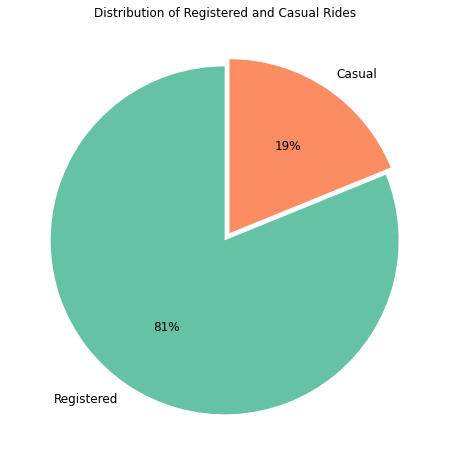

Count of registered users: 2621296
Count of casual users: 608905


In [30]:
plt.figure(figsize=(8, 8))

registered_sum = hour_df['registered'].sum()
casual_sum = hour_df['casual'].sum()

# Create a pie chart using the pieplot function
data = [registered_sum, casual_sum]
labels = ["Registered", "Casual"]
colors = ["red", "lightcoral"]
explode = [0, 0.05] 

palette_color = sns.color_palette('Set2') 
  
# plotting data on chart 
plt.pie(data, labels=labels, colors=palette_color, 
        explode=explode, autopct='%.0f%%',textprops={'fontsize': 12}, startangle = 90) 

# Add a title to the plot
plt.title("Distribution of Registered and Casual Rides")

# Show the plot
plt.show()

print(f"Count of registered users: {registered_sum}")
print(f"Count of casual users: {casual_sum}")


### Time series plot of bikeshare users

In [31]:
hour_df.head()

,index,instant,dteday,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,0,1,2011-01-01,Winter,2011,January,0,0,Saturday,0,1,9.84,14.395,81.0,0.0,3,13,16
1,1,2,2011-01-01,Winter,2011,January,1,0,Saturday,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2,3,2011-01-01,Winter,2011,January,2,0,Saturday,0,1,9.02,13.635,80.0,0.0,5,27,32
3,3,4,2011-01-01,Winter,2011,January,3,0,Saturday,0,1,9.84,14.395,75.0,0.0,3,10,13
4,4,5,2011-01-01,Winter,2011,January,4,0,Saturday,0,1,9.84,14.395,75.0,0.0,0,1,1


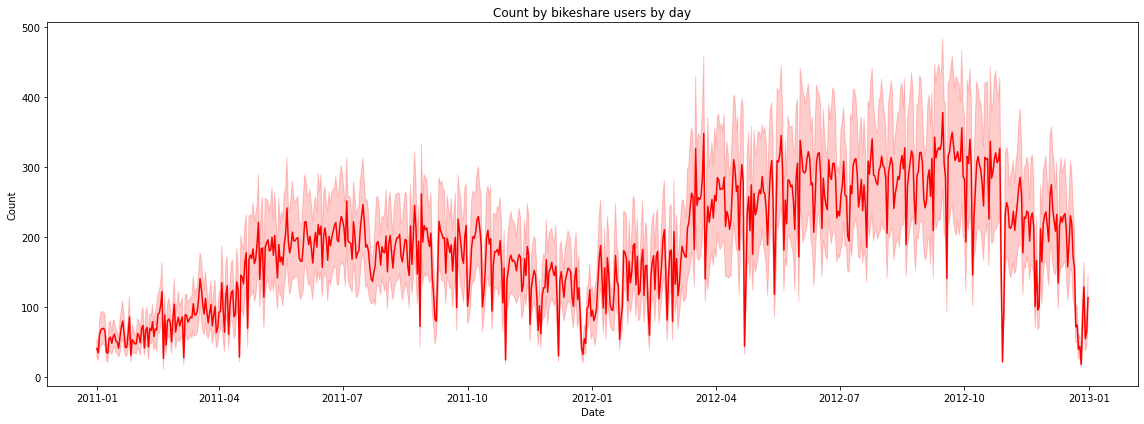

In [32]:
plt.figure(figsize=(16,6))

# Create a line plot using the sns.lineplot() function
sns.lineplot(x="dteday", y="count", data=hour_df, color='red')

# Add labels and a title to the plot
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Count by bikeshare users by day")

# Show the plot
plt.tight_layout()
plt.show()

- The count of rides starts low in the beginning of each year, then starts to increase in the middle of the year, then decreased nearing the end of each year.
- The number of users seems higher in 2012 than in 2011.

### Count of bikes during weekdays and weekends

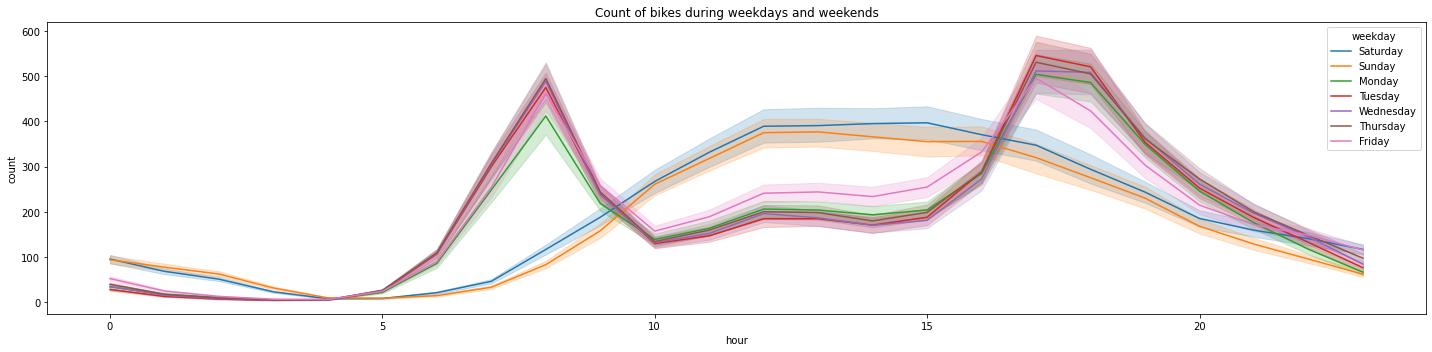

In [33]:

plt.figure(figsize=(20,5))
sns.lineplot(data=hour_df, x='hour', y='count', hue='weekday')
plt.xlabel("hour")
plt.ylabel("count")
plt.title("Count of bikes during weekdays and weekends")

# Show the plot
plt.tight_layout()
plt.show()

### Lineplot of bikeshare users by holiday

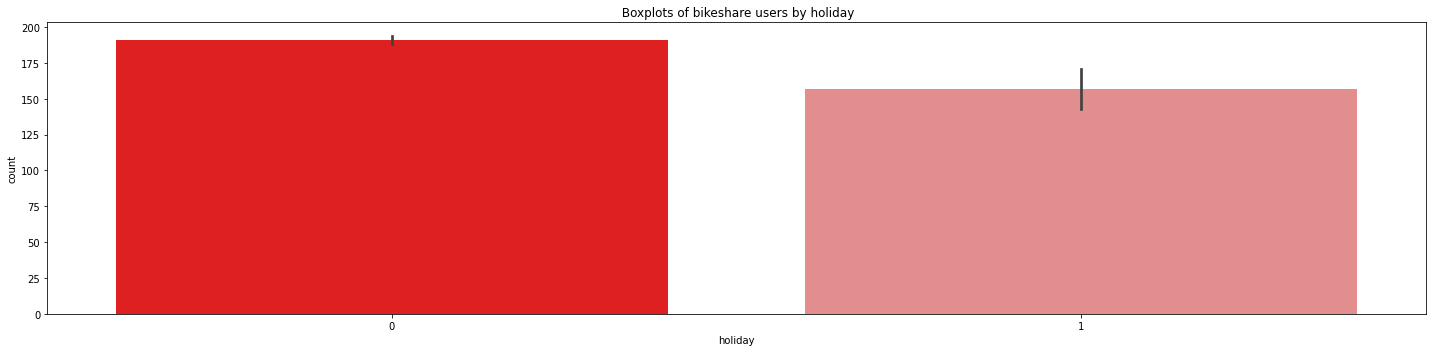

Count of bikeshare users based on holiday:
0    16524
1      492
Name: holiday, dtype: int64


In [34]:
plt.figure(figsize=(20,5))
sns.barplot(data=hour_df, x='holiday', y='count', palette=["red", "lightcoral"])
plt.xlabel("holiday")
plt.ylabel("count")
plt.title(" Boxplots of bikeshare users by holiday")

# Show the plot
plt.tight_layout()
plt.show()


print('Count of bikeshare users based on holiday:')
print(hour_df['holiday'].value_counts())

### Boxplots of bikeshare users by workingday

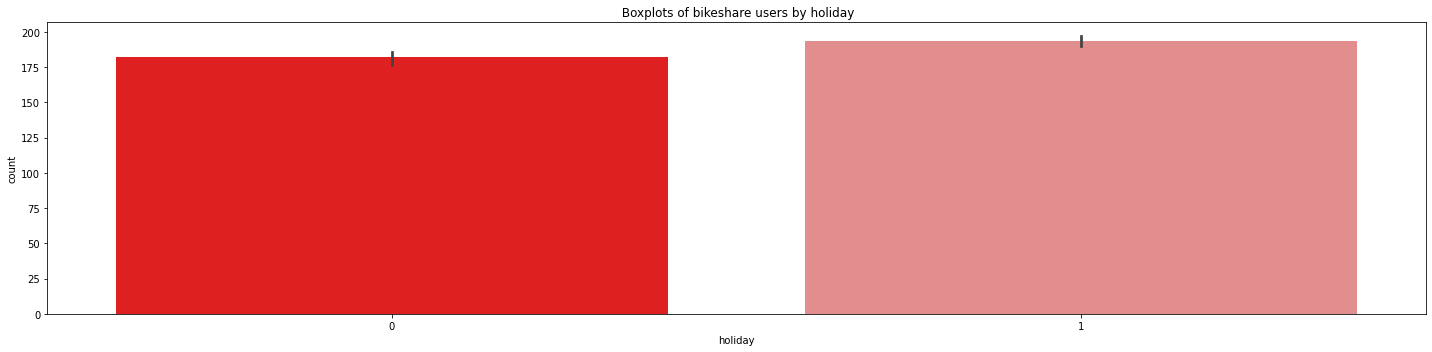

Count of bikeshare users based on holiday:
1    11618
0     5398
Name: workingday, dtype: int64


In [35]:
plt.figure(figsize=(20,5))
sns.barplot(data=hour_df, x='workingday', y='count', palette=["red", "lightcoral"])
plt.xlabel("holiday")
plt.ylabel("count")
plt.title(" Boxplots of bikeshare users by holiday")

# Show the plot
plt.tight_layout()
plt.show()


print('Count of bikeshare users based on holiday:')
print(hour_df['workingday'].value_counts())

### Scatterplot of temperature, feeling temperature, humidity. and windspeed vs. count of bikeshare users

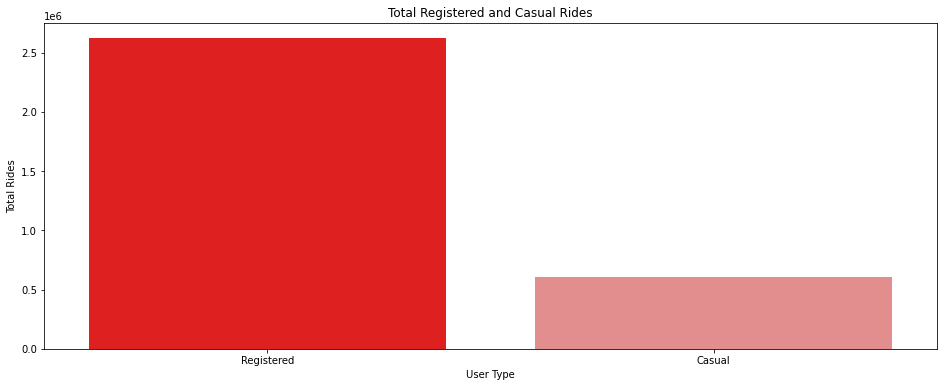

Count of registered users: 2621296
Count of casual users: 608905


In [36]:
registered_sum = hour_df['registered'].sum()
casual_sum = hour_df['casual'].sum()

plt.figure(figsize=(16,6))

# Create a bar chart using the plt.bar() function
sns.barplot(x=["Registered", "Casual"], y=[registered_sum, casual_sum],  palette=["red", "lightcoral"])

# Add labels and a title to the plot
plt.xlabel("User Type")
plt.ylabel("Total Rides")
plt.title("Total Registered and Casual Rides")

# Show the plot
plt.show()

print(f"Count of registered users: {registered_sum}")
print(f"Count of casual users: {casual_sum}")

### Number of rides by month

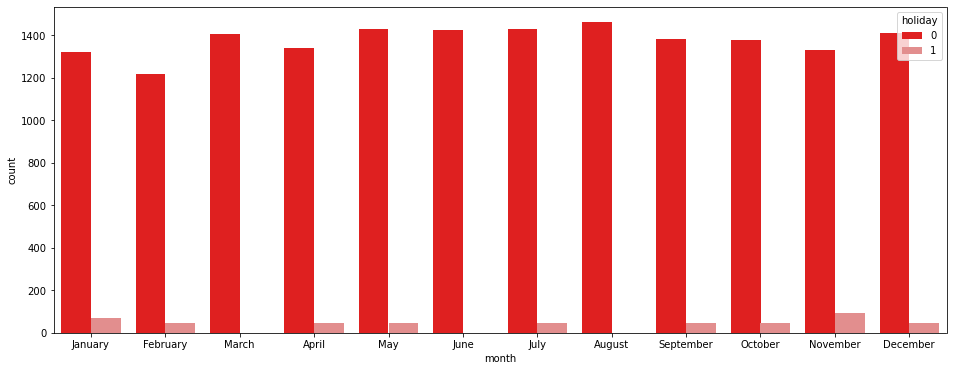

In [37]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(16,6))
sns.countplot(x='month', data=hour_df, order=month_order, hue='holiday',  palette=["red", "lightcoral"])
plt.show()

### Number of rides by season

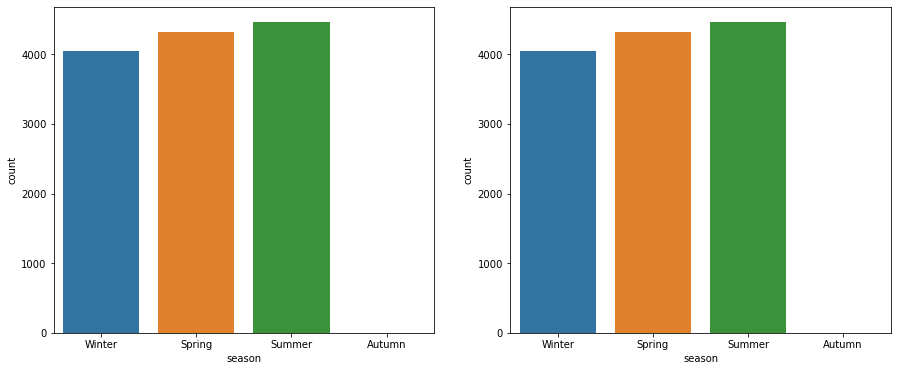

In [38]:
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']

fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0] = sns.countplot(ax=axes[0], x='season', order=season_order, data=hour_df)
axes[1] = sns.countplot(ax=axes[1], x='season', order=season_order, data=hour_df)
plt.show()

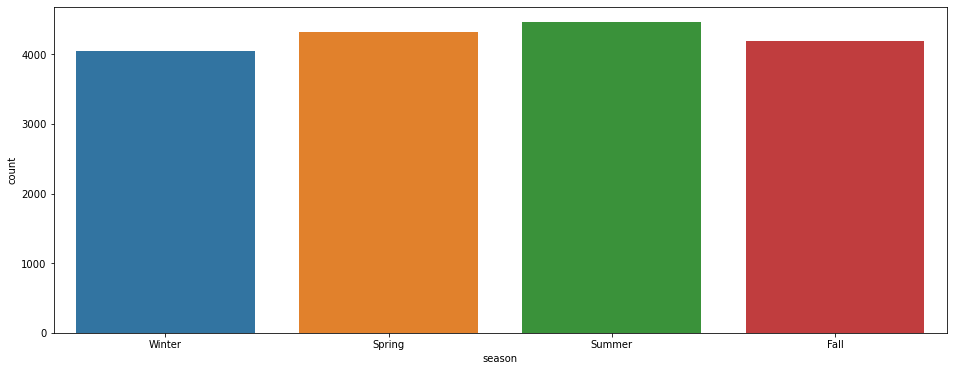

In [39]:
plt.figure(figsize=(16,6))
sns.countplot(x='season', data=hour_df)
plt.show()

### 5.1 What are the trends in bike-sharing rides?


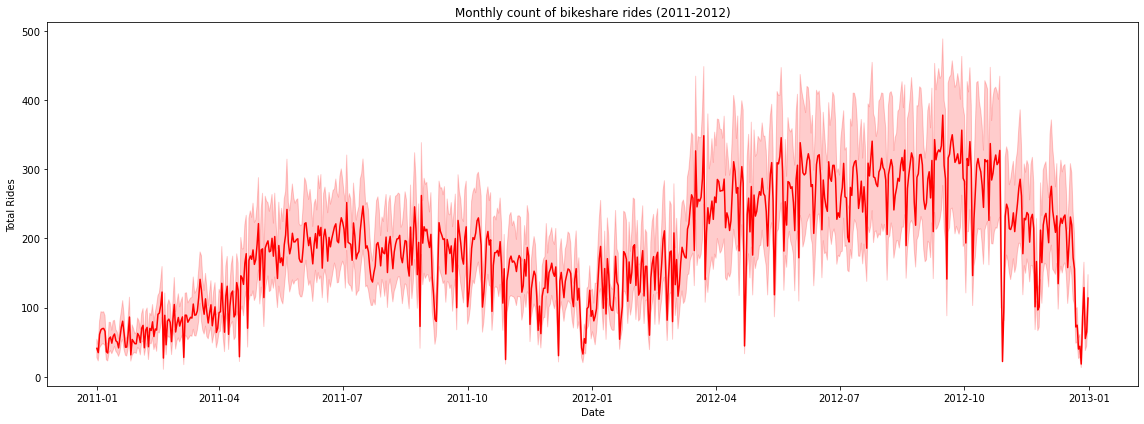

In [40]:
plt.figure(figsize=(16,6))

# Create a line plot using the sns.lineplot() function
sns.lineplot(x="dteday", y="count", data=hour_df, color='red')

# Add labels and a title to the plot
plt.xlabel("Date")
plt.ylabel("Total Rides")
plt.title("Monthly count of bikeshare rides (2011-2012)")

# Show the plot
plt.tight_layout()
plt.show()

To make it more interpretable, let's pivot it to monthly figure. Using `resample`, we will aggregate the time-series based data (from daily to monthly)

In [41]:
monthly_users_df = hour_df.resample(rule='M', on='dteday').agg({
    "casual": "sum",
    "registered": "sum",
    "count": "sum"
})

monthly_users_df.head(3)

,casual,registered,count
dteday,,,
2011-01-31,3024,34528,37552
2011-02-28,5505,38010,43515
2011-03-31,12497,49866,62363


In [42]:
monthly_users_df.index = monthly_users_df.index.strftime('%b %y')

In [43]:
monthly_users_df.head(3)

,casual,registered,count
dteday,,,
Jan 11,3024,34528,37552
Feb 11,5505,38010,43515
Mar 11,12497,49866,62363


In [44]:
monthly_users_df = monthly_users_df.reset_index()

In [45]:
monthly_users_df = monthly_users_df.rename(columns={'dteday': 'yearmonth'})

In [46]:
monthly_users_df.head()

,yearmonth,casual,registered,count
0,Jan 11,3024,34528,37552
1,Feb 11,5505,38010,43515
2,Mar 11,12497,49866,62363
3,Apr 11,21213,68791,90004
4,May 11,30782,103943,134725


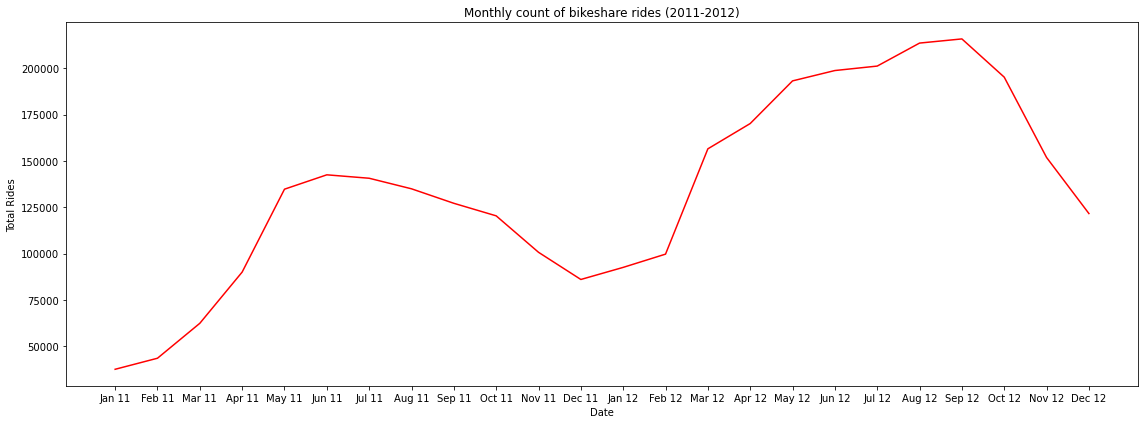

In [47]:
plt.figure(figsize=(16,6))

# Create a line plot using the sns.lineplot() function
sns.lineplot(x="yearmonth", y="count", data=monthly_users_df, color='red')

# Add labels and a title to the plot
plt.xlabel("Date")
plt.ylabel("Total Rides")
plt.title("Monthly count of bikeshare rides (2011-2012)")

# Show the plot
plt.tight_layout()
plt.show()

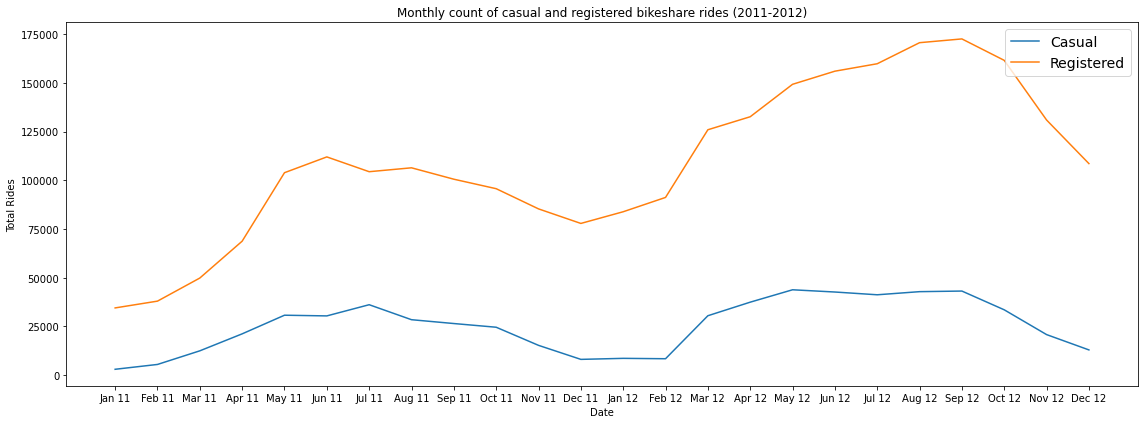

In [48]:
plt.figure(figsize=(16,6))

# Create a line plot using the sns.lineplot() function
sns.lineplot(x="yearmonth", y="casual", data=monthly_users_df, label='Casual')
sns.lineplot(x="yearmonth", y="registered", data=monthly_users_df, label='Registered')

# Add labels and a title to the plot
plt.xlabel("Date")
plt.ylabel("Total Rides")
plt.title("Monthly count of casual and registered bikeshare rides (2011-2012)")

# Add a legend to the plot
plt.legend(loc='upper right', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

**Insight**
- The number of bikeshare rides in 2012 exceeds that of 2011.
- Seasonal patterns are evident in both of these years. The count of bikeshare rides typically begins the year with lower numbers, then shows an increase in Q2, followed by a decrease in Q4.
- Registered bikeshare rides outnumber casual rides, although both exhibit the same annual trend.

### 5.2 How do people use bike-sharing services throughout the day? 

In [49]:
hourly_users_df = hour_df.groupby("hour").agg({
    "casual": "sum",
    "registered": "sum",
    "count": "sum"
})

hourly_users_df.head()

,casual,registered,count
hour,,,
0,7352,31632,38984
1,4704,19397,24101
2,3399,12848,16247
3,1881,6238,8119
4,869,3538,4407


In [50]:
hourly_users_df = hourly_users_df.reset_index()

In [51]:
hourly_users_df.head()

,hour,casual,registered,count
0,0,7352,31632,38984
1,1,4704,19397,24101
2,2,3399,12848,16247
3,3,1881,6238,8119
4,4,869,3538,4407


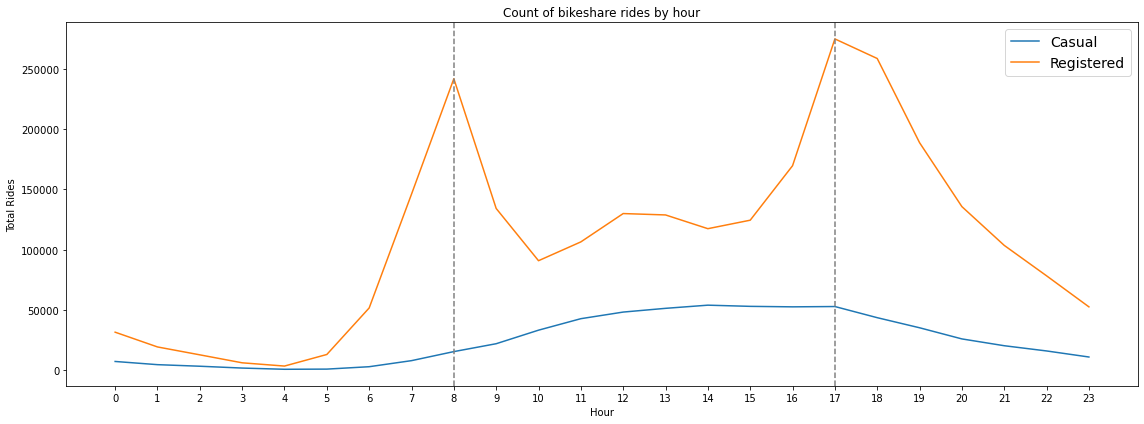

In [52]:
plt.figure(figsize=(16,6))

# Create a line plot using the sns.lineplot() function
sns.lineplot(x="hour", y="casual", data=hourly_users_df, label='Casual')
sns.lineplot(x="hour", y="registered", data=hourly_users_df, label='Registered')

# Add labels and a title to the plot
x = np.arange(0, 24, 1)
plt.xticks(x)

plt.xlabel("Hour")
plt.ylabel("Total Rides")
plt.title("Count of bikeshare rides by hour")

# highlight the important data label in the chart
plt.axvline(x=8, color='gray', linestyle='--')
plt.axvline(x=17, color='gray', linestyle='--')

# Add a legend to the plot
plt.legend(loc='upper right', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

**Insight**
1. The above chart shows very obvious different pattern on how casual and registered bikeshare rides differs based on hour in a day.
2. The registered bikeshare rides shows peak on 8.00 and 17.00. Given both these hours are time when people go to work and coming back from work, it's possible that registered bikeshare users use the bike to commute to work.
3. On the other hand, casual bikeshare rides shows higher frequency  during the day, then it starts to decrease after 17.00.

### 5.3 How does weather affect bike-sharing usage?

Let's recall the weather situation in `weathersit` variable:

- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [53]:
weatherly_users_df = hour_df.groupby("weather").agg({
    "casual": "sum",
    "registered": "sum",
    "count": "sum"
})

weatherly_users_df

,casual,registered,count
weather,,,
1,454752,1840597,2295349
2,132383,650463,782846
3,21762,130021,151783
4,8,215,223


In [54]:
weatherly_users_df = weatherly_users_df.reset_index()

In [55]:
weatherly_users_df

,weather,casual,registered,count
0,1,454752,1840597,2295349
1,2,132383,650463,782846
2,3,21762,130021,151783
3,4,8,215,223


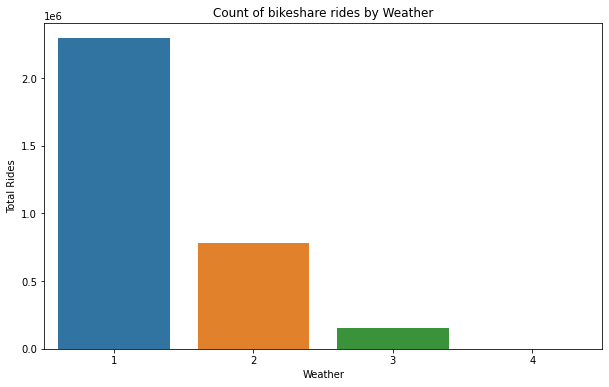

In [56]:
plt.figure(figsize=(10,6))

sns.barplot(x="weather", y="count", data=weatherly_users_df)

plt.xlabel("Weather")
plt.ylabel("Total Rides")
plt.title("Count of bikeshare rides by Weather")

plt.show()

### 5.4 Which season has the most bike-sharing activity? 

In [57]:
seasonly_users_df = hour_df.groupby("season").agg({
    "casual": "sum",
    "registered": "sum",
    "count": "sum"
})

seasonly_users_df.head()

,casual,registered,count
season,,,
Fall,127636,704126,831762
Spring,199638,699798,899436
Summer,223909,827289,1051198
Winter,57722,390083,447805


In [58]:
seasonly_users_df = seasonly_users_df.reset_index()

In [59]:
seasonly_users_df

,season,casual,registered,count
0,Fall,127636,704126,831762
1,Spring,199638,699798,899436
2,Summer,223909,827289,1051198
3,Winter,57722,390083,447805


In [60]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']

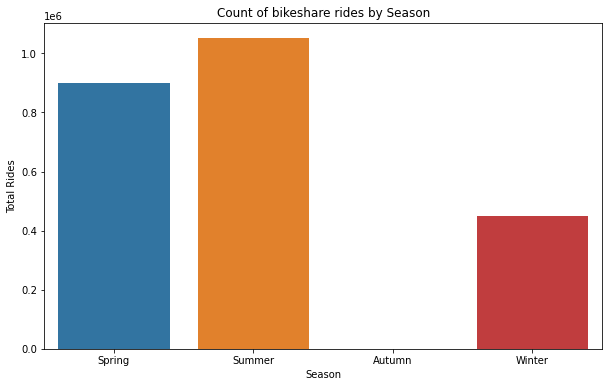

In [61]:
plt.figure(figsize=(10,6))

sns.barplot(x="season", y="count", data=seasonly_users_df, order=season_order)

plt.xlabel("Season")
plt.ylabel("Total Rides")
plt.title("Count of bikeshare rides by Season")

plt.show()

- The count of bikeshare users are highest during Summer season, and lowest during Winter season.
- Further, to see the difference between casual and registered bikeshare users pattern in each season, we will unpivot the `season_users_df`

In [62]:
seasonly_users_df_unpivoted = pd.melt(seasonly_users_df,
                                      id_vars=['season'],
                                      value_vars=['casual', 'registered'],
                                      var_name='status',
                                      value_name='count')

C:\Users\Reinaldo\AppData\Local\Temp\ipykernel_22092\3697637476.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  seasonly_users_df_unpivoted = pd.melt(seasonly_users_df,


In [63]:
seasonly_users_df_unpivoted

,season,status,count
0,Fall,casual,127636
1,Spring,casual,199638
2,Summer,casual,223909
3,Winter,casual,57722
4,Fall,registered,704126
5,Spring,registered,699798
6,Summer,registered,827289
7,Winter,registered,390083


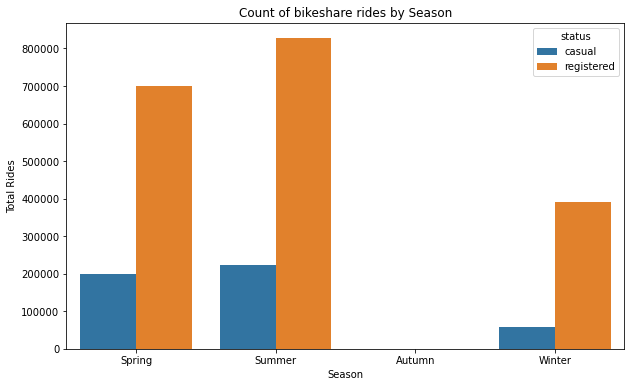

In [64]:
plt.figure(figsize=(10,6))

sns.barplot(x='season', y='count', data=seasonly_users_df_unpivoted, order=season_order, hue='status')

plt.xlabel("Season")
plt.ylabel("Total Rides")
plt.title("Count of bikeshare rides by Season")

plt.show()

**Insight**
- The count of bikeshare rides are highest during Summer season, and lowest during Winter season.
- There are no major difference between casual and registered rides pattern during season, both are highest in Summer and lowest during Winter.

### 5.5 How do people use bike-sharing on weekdays and weekends?

In [65]:
weekday_users_df = hour_df.groupby("weekday").agg({
    "casual": "sum",
    "registered": "sum",
    "count": "sum"
})

weekday_users_df

,casual,registered,count
weekday,,,
Friday,77141,401256,478397
Monday,68637,377343,445980
Saturday,150856,316915,467771
Sunday,138612,298459,437071
Thursday,60219,415033,475252
Tuesday,56828,403846,460674
Wednesday,56612,408444,465056


In [66]:
weekday_users_df = weekday_users_df.reset_index()

In [67]:
weekday_users_df

,weekday,casual,registered,count
0,Friday,77141,401256,478397
1,Monday,68637,377343,445980
2,Saturday,150856,316915,467771
3,Sunday,138612,298459,437071
4,Thursday,60219,415033,475252
5,Tuesday,56828,403846,460674
6,Wednesday,56612,408444,465056


In [68]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

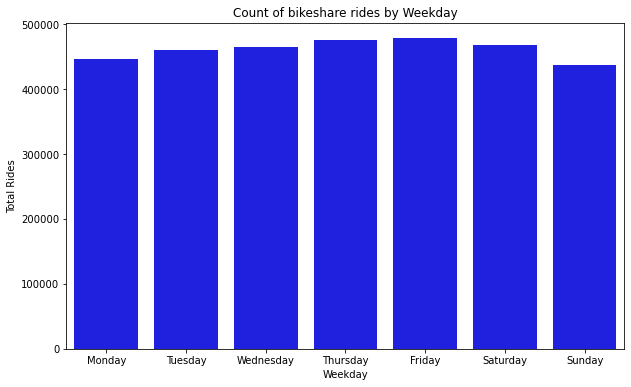

In [69]:
plt.figure(figsize=(10,6))

sns.barplot(x='weekday', y='count', data=weekday_users_df, order=day_order, color='blue')

plt.xlabel("Weekday")
plt.ylabel("Total Rides")
plt.title("Count of bikeshare rides by Weekday")

plt.show()

- It seems like the count of bikeshare users are spaced quite evenly during the weekday
- Further, to see the difference between casual and registered bikeshare users pattern during weekday, we will unpivot the `weekday_users_df`

In [70]:
weekday_users_df_unpivoted = pd.melt(weekday_users_df,
                                      id_vars=['weekday'],
                                      value_vars=['casual', 'registered'],
                                      var_name='status',
                                      value_name='count')

C:\Users\Reinaldo\AppData\Local\Temp\ipykernel_22092\2584307103.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  weekday_users_df_unpivoted = pd.melt(weekday_users_df,


In [71]:
weekday_users_df_unpivoted

,weekday,status,count
0,Friday,casual,77141
1,Monday,casual,68637
2,Saturday,casual,150856
3,Sunday,casual,138612
4,Thursday,casual,60219
5,Tuesday,casual,56828
6,Wednesday,casual,56612
7,Friday,registered,401256
8,Monday,registered,377343
9,Saturday,registered,316915


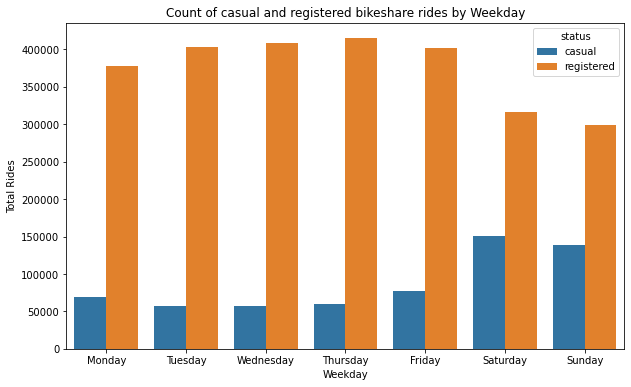

In [72]:
plt.figure(figsize=(10,6))

sns.barplot(x='weekday', y='count', data=weekday_users_df_unpivoted, order=day_order, hue='status')

plt.xlabel("Weekday")
plt.ylabel("Total Rides")
plt.title("Count of casual and registered bikeshare rides by Weekday")

plt.show()

In [73]:
def categorize_weekday(weekday):
    if weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']:
        return 'Weekday'
    else:
        return 'Weekend'
weekday_users_df_unpivoted['day_type'] = weekday_users_df_unpivoted['weekday'].apply(categorize_weekday)
weekday_users_df_unpivoted_week = weekday_users_df_unpivoted.groupby(['day_type', 'status'])['count'].sum().reset_index()
weekday_users_df_unpivoted_week = weekday_users_df_unpivoted_week.rename(columns={'day_type': 'weekday'})

weekday_users_df_unpivoted_week

,weekday,status,count
0,Weekday,casual,319437
1,Weekday,registered,2005922
2,Weekend,casual,289468
3,Weekend,registered,615374


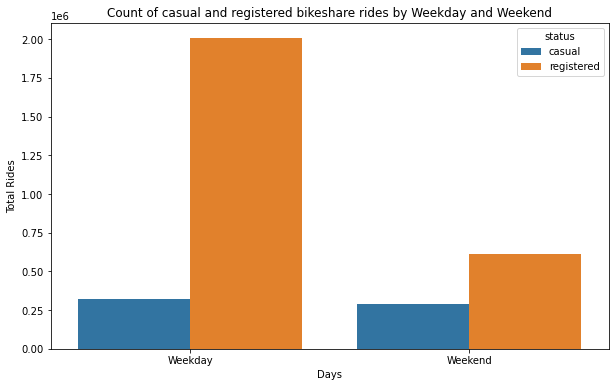

In [74]:
weekday_order =['Weekday', 'Weekend']
plt.figure(figsize=(10,6))

sns.barplot(x='weekday', y='count', data=weekday_users_df_unpivoted_week, order=weekday_order, hue='status')

plt.xlabel("Days")
plt.ylabel("Total Rides")
plt.title("Count of casual and registered bikeshare rides by Weekday and Weekend")

plt.show()

**Insight**
1. When we separate the count of bikeshare rides between casual and registered users, we see an interesting pattern here.
2. The count of casual rides are higher on the weekend, while for registered rides are higher on the weekday.
3. Adding to the insight we found on hourly rides, this further supports that registered users probably used the bike for work routinely during weekday, while the casual users used the bike for casual leisure on weekend.

### 5.6 How does bike-sharing on national holidays?

In [75]:
holiday_users_df = hour_df.groupby("holiday").agg({
    "casual": "sum",
    "registered": "sum",
    "count": "sum"
})

holiday_users_df

,casual,registered,count
holiday,,,
0,586850,2566165,3153015
1,22055,55131,77186


In [76]:
holiday_users_df = holiday_users_df.reset_index()

In [77]:
holiday_users_df

,holiday,casual,registered,count
0,0,586850,2566165,3153015
1,1,22055,55131,77186


In [78]:
holiday_users_df_unpivoted = pd.melt(holiday_users_df,
                                      id_vars=['holiday'],
                                      value_vars=['casual', 'registered'],
                                      var_name='status',
                                      value_name='count')

C:\Users\Reinaldo\AppData\Local\Temp\ipykernel_22092\2403302643.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  holiday_users_df_unpivoted = pd.melt(holiday_users_df,


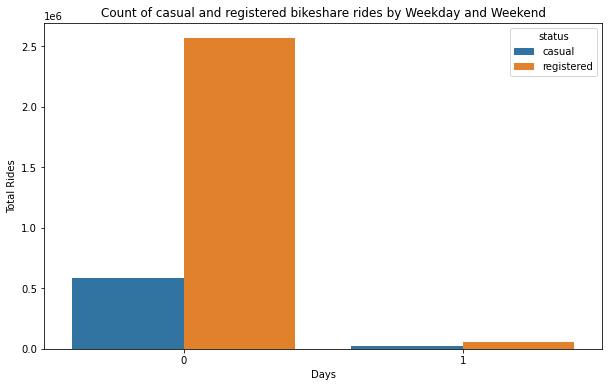

In [79]:
plt.figure(figsize=(10,6))

sns.barplot(x='holiday', y='count', data=holiday_users_df_unpivoted, hue='status')

plt.xlabel("Days")
plt.ylabel("Total Rides")
plt.title("Count of casual and registered bikeshare rides by Weekday and Weekend")

plt.show()

## Business Recommendation
---
1. Introduce Weekend Pass. The Weekend Pass is targeted to casual riders who mostly rent a bike during weekend. The Weekend Pass will have lower price point than the Annual Pass, but can only be used during Friday, Saturday, and Sunday.

2. Create a reward point campaign; give user reward points which accumulated by riding duration. Since casual riders ride duration is higher than current member riders, they will benefit more from this campaign. Offer them membership discount when they reach certain points to convert them into Cyclistic's member.

3. Perform strategic campaign during summer. Given the number of riders are at its annual peak in summer, we can do strategic campaign and advertising to reach more audience. 